In [28]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'SW', 'SOLV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425230   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622635   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

In [29]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425230   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361626   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622635   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146741  4.485761   
           YUM       1500600.0         -0.000051  36.057182  4.811707   
           ZBH       3610500.0          0.000022  31.893242  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623478  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782188  
           AAL          NaN       NaN       NaN       NaN     279.420126  
           AAPL         NaN       NaN       NaN       NaN    7225.797830  
           ABBV         NaN       NaN       NaN       NaN     462.394152  
           ABT          NaN       NaN       NaN       NaN     409.198630  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159188     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363695     183.389847  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.212559  5.271371  0.651515 -1.188278     256.251875  

[985955 rows x 14 columns]

In [30]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.740910   38.950905         -0.002098  73.421576   
           AAL        287.915794   39.429932         -0.000966  40.719000   
           AAPL      4019.331634   26.823090         -0.003391  55.537358   
           ABBV       334.491201   40.025848         -0.062372  49.376897   
           ABT        210.542059   38.091476         -0.011927  56.962485   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       153.715885   78.028648         -0.000190  33.116284   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.304720  107.661484          0.000080  55.245460   
           GEHC       212.197216   66.105721          0.000185  40.922336   
           KVUE       664.360298   19.814007         -0.000410  35.706318   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689081 -1.033887  0.567158  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.280565  3.323875  3.367185 -0.967900 -0.142789  
           ABBV    3.717771  3.766009  3.814247 -0.526809  0.145677  
           ABT     3.650901  3.672752  3.694603 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.365997  4.411282  4.456568 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366876  
           GEHC    4.155071  4.212607  4.270142 -0.893478 -1.116463  
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435622  

[46553 rows x 9 columns]

In [31]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134335         -0.000176  62.203595  3.604673   
           AAPL     26.182175         -0.002541  49.891155  3.293123   
           ABBV     39.878784         -0.049190  27.477832  3.744517   
           ABT      34.112484         -0.008074  38.008890  3.549492   
           ACN     103.117393         -0.005023  53.823634  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 XOM     112.466652         -0.000205  59.440197  4.679146   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131596  
           AAPL    3.322002  3.350880 -1.038688 -0.195978  
           ABBV    3.798670  3.852823 -0.893132 -0.760593  
           ABT     3.599959  3.650426 -1.035224 -0.650888  
           ACN     4.644646  4.656283 -0.996806 -0.135457  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.719239  4.759332  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [32]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051796  3.849110   
           AAPL     39.667980         -0.001105  69.196752  3.593605   
           ABBV     66.876801         -0.036142  55.247884  4.187696   
           ABT      48.237457         -0.005677  53.844876  3.887385   
           ACN     128.834686         -0.004274  69.365034  4.798335   
...                       ...               ...        ...       ...   
2023-09-30 XOM     112.466652         -0.000205  59.440197  4.679146   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.640476  3.687347 -0.906642 -0.039276   0.096808   
           ABBV    4.234050  4.280405  0.375557  0.473813   0.022728   
           ABT     3.910952  3.934519 -1.040044  0.276132   0.021275   
           ACN     4.838013  4.877691 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.719239  4.759332  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10344 rows x 14 columns]

In [33]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10344 rows x 6 columns]

In [34]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10309 rows x 6 columns]

In [35]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456089 -0.460026 -0.281339 -0.074279  0.761453
           VZ      0.331582 -0.173420  0.290305  0.315697  0.071478
           WFC     1.119315  0.309055  2.035946 -0.441943 -1.504622
           WMT     0.700666 -0.312947 -0.416685 -0.138961  0.516750
           XOM     0.978565 -1.095950  1.773612 -0.624865 -0.412274

[10309 rows x 5 columns]

In [36]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10127 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10127 non-null  float64
 1   rsi               10127 non-null  float64
 2   bb_low            10127 non-null  float64
 3   bb_mid            10127 non-null  float64
 4   bb_high           10127 non-null  float64
 5   atr               10127 non-null  float64
 6   macd              10127 non-null  float64
 7   return_1m         10127 non-null  float64
 8   return_2m         10127 non-null  float64
 9   return_3m         10127 non-null  float64
 10  return_6m         10127 non-null  float64
 11  return_9m         10127 non-null  float64
 12  return_12m        10127 non-null  float64
 13  Mkt-RF            10127 non-null  float64
 14  SMB               10127 non-null  float64
 15  HML       

In [39]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids 

data = data.drop('cluster', axis = 1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids ).fit(df).labels_
    return df
    

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051796  3.849110  3.921750  3.994389   
           AAPL           -0.001105  69.196752  3.593605  3.640476  3.687347   
           ABBV           -0.036142  55.247884  4.187696  4.234050  4.280405   
           ABT            -0.005677  53.844876  3.887385  3.910952  3.934519   
           ACN            -0.004274  69.365034  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000074  54.722542  3.982183  3.999651  4.017120   
           XOM            -0.000205  59.440197  4.679146  4.719239  4.759332   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039276   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473813   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276132   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.263867  1.322360   
           AAPL     0.028875   0.038941    0.035228  1.273284 -0.270026   
           ABBV     0.056495   0.047273    0.044026  0.494007  0.372028   
           ABT      0.038672   0.031320    0.029294  0.829746 -0.202847   
           ACN      0.028692   0.027398    0.018728  1.199274 -0.166731   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740334 -0.259860   
           XOM      0.012838   0.008747    0.027037  1.001239 -1.055138   
           MRNA    -0.071952  -0.064976   -0.015431  1.155517  0.767772   
           UBER     0.057244   0.066838    0.043691  1.080479  1.180797   
           CRWD     0.026391   0.047942   -0.002216  0.595945 -0.916784   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.589851  0.475525  0.574169        0  
           AAPL   -0.592821  0.656514  0.458467        2  
           ABBV   -0.045654  0.257910  0.183430        3  
           ABT    -0.528481  0.244478  0.972082        3  
           ACN    -0.329661  0.266732  0.173059        2  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.524398 -0.124576  0.651561        2  
           XOM     1.725822 -0.658415 -0.329149        1  
           MRNA   -1.156852  0.597846  0.995470        3  
           UBER   -0.303488 -1.488702 -0.381346        3  
           CRWD   -0.739516 -2.459211 -0.722896        2  

[10127 rows x 19 columns]

In [40]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

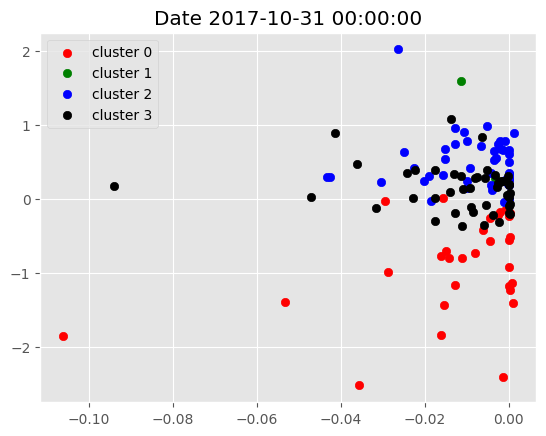

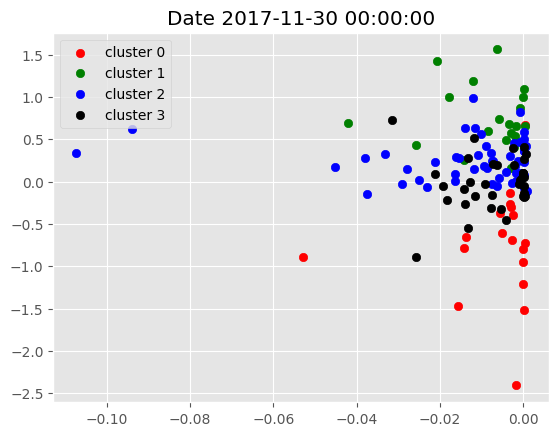

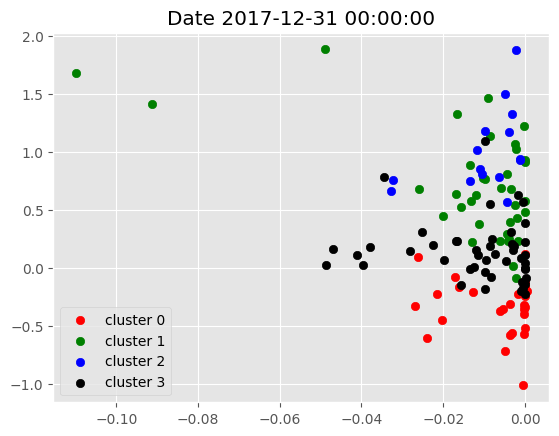

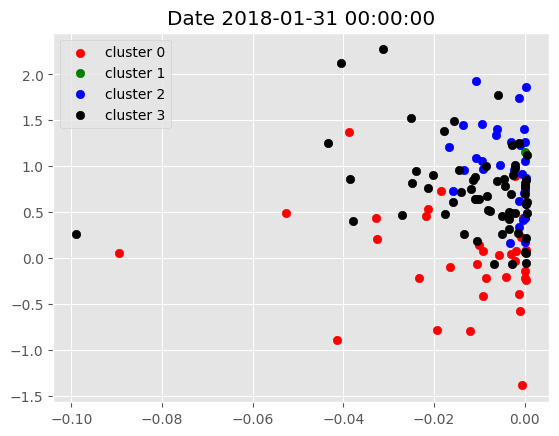

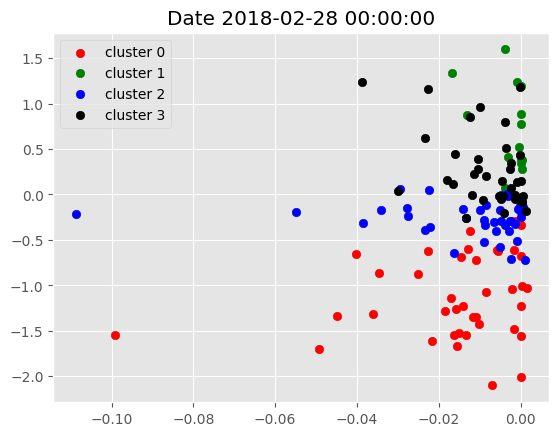

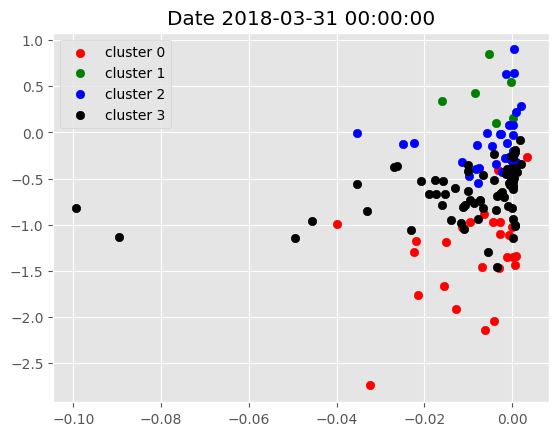

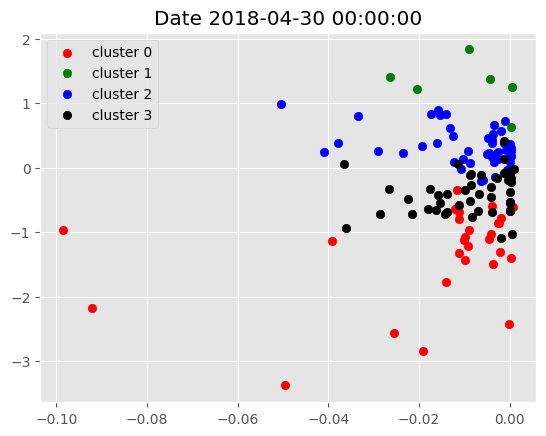

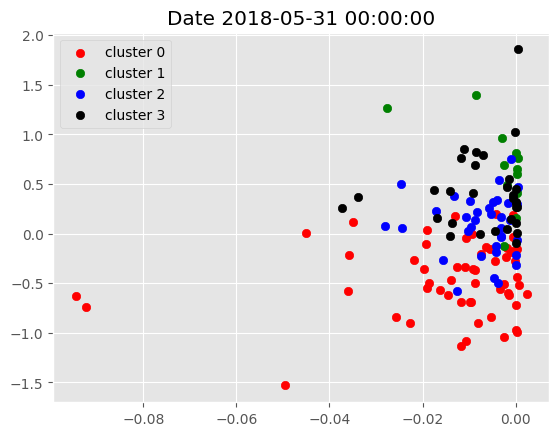

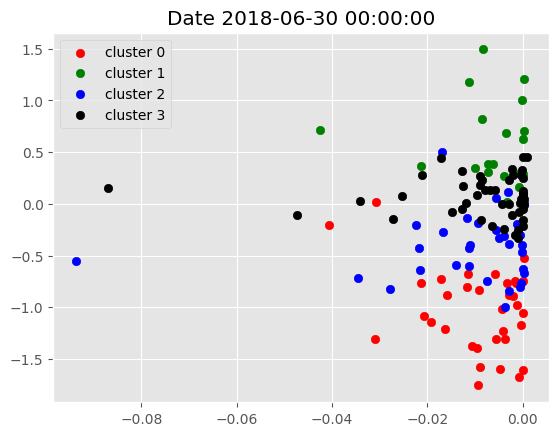

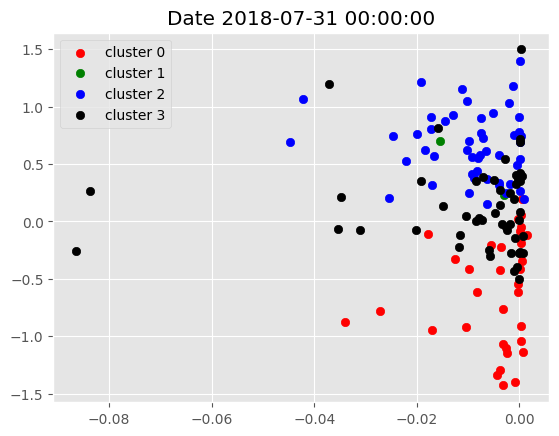

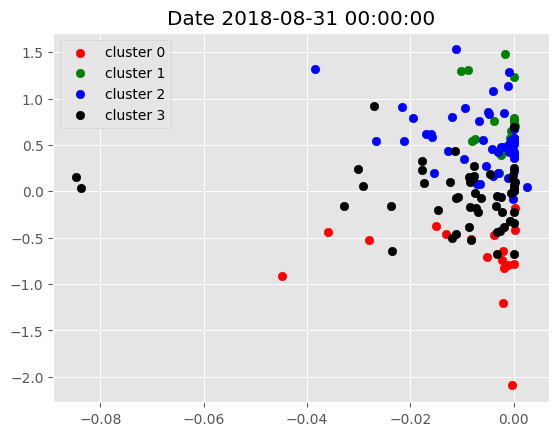

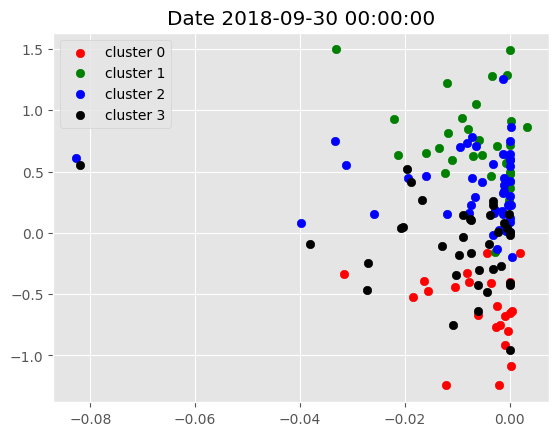

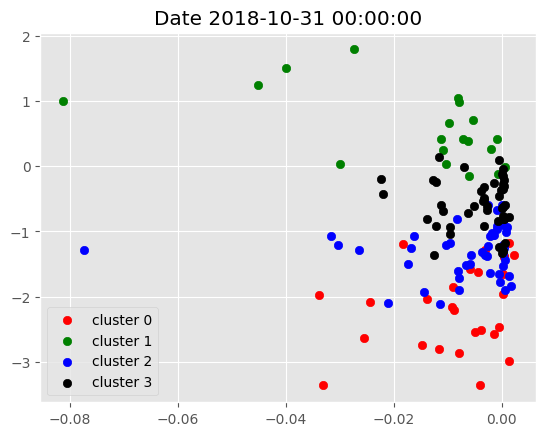

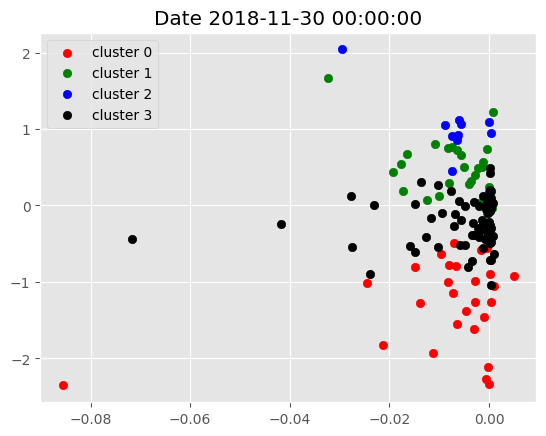

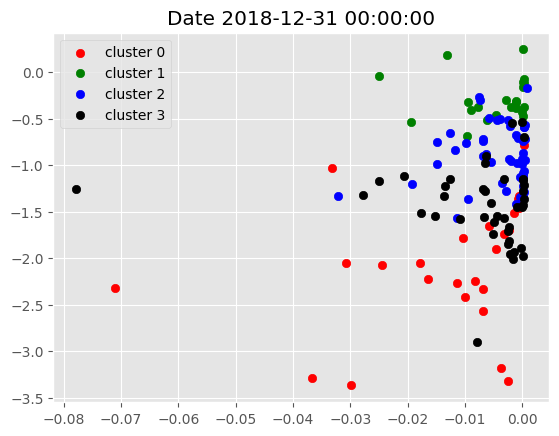

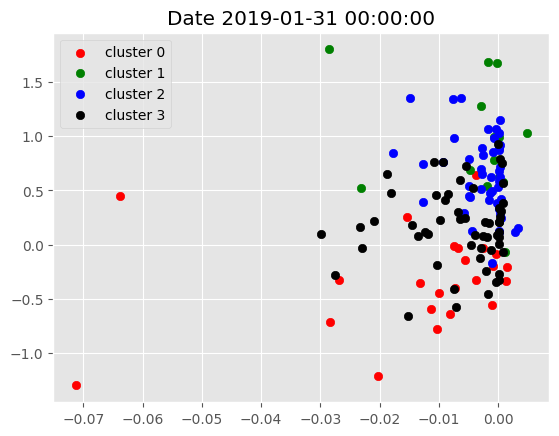

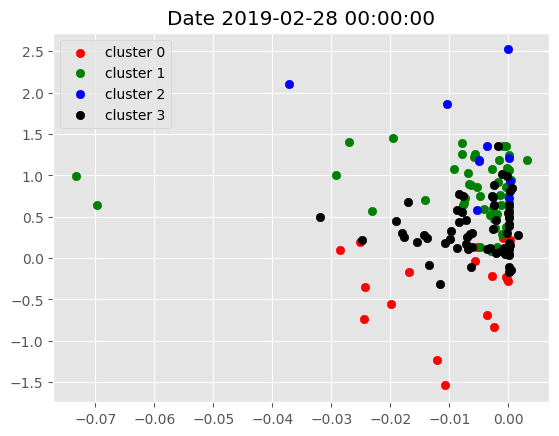

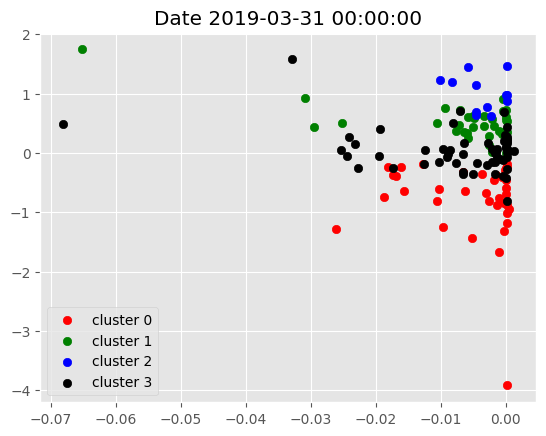

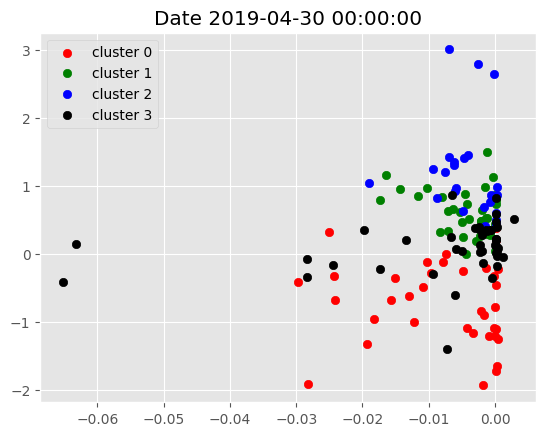

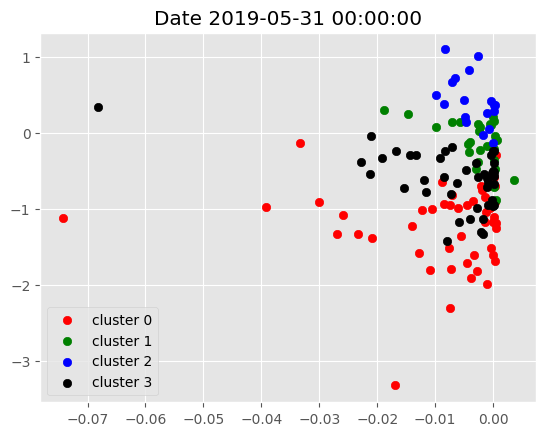

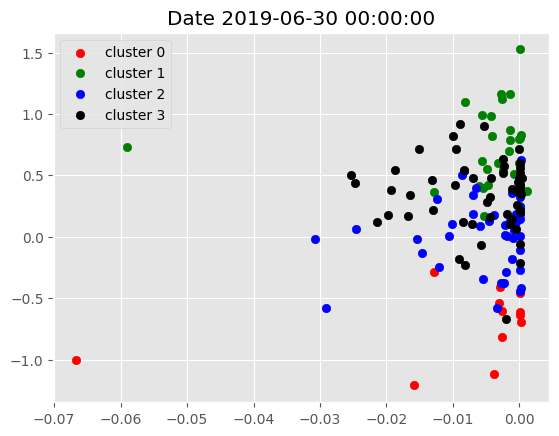

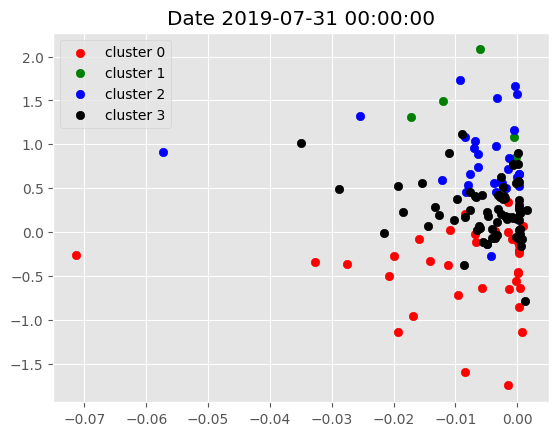

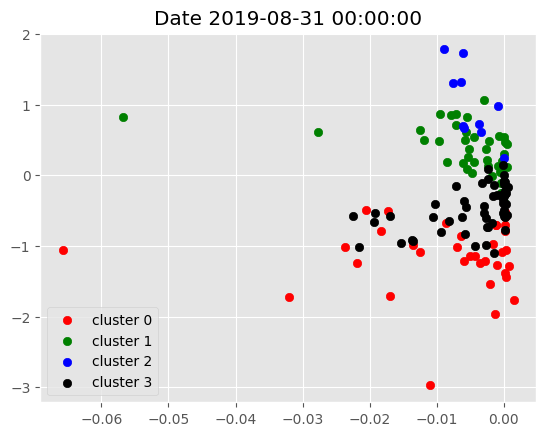

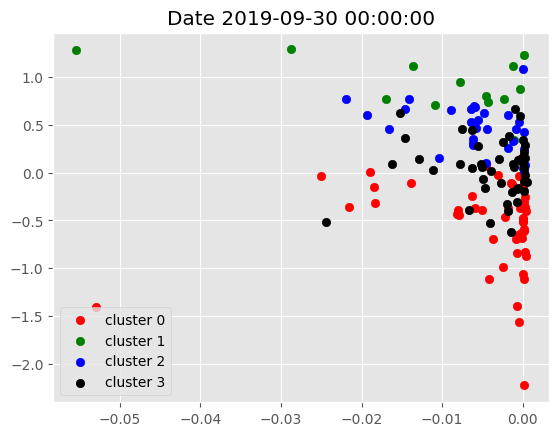

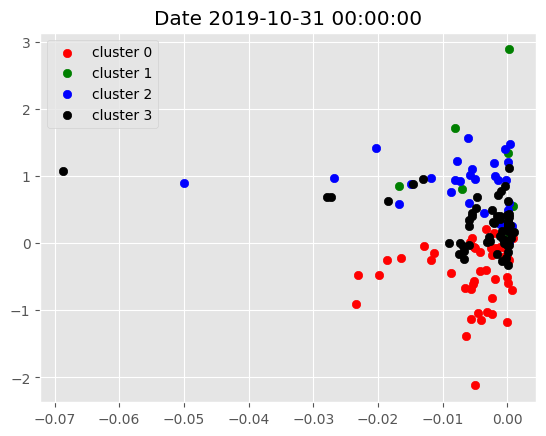

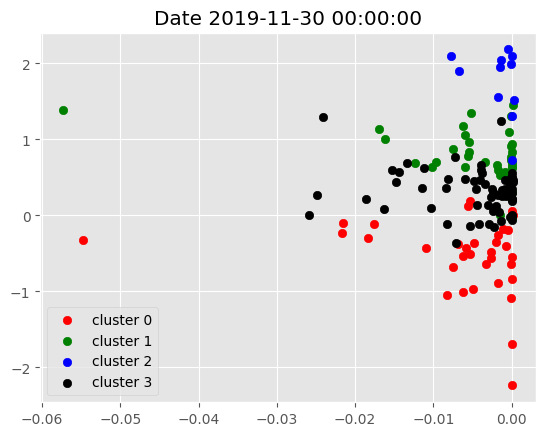

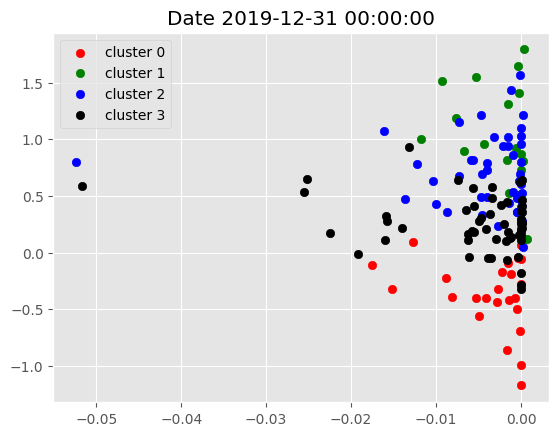

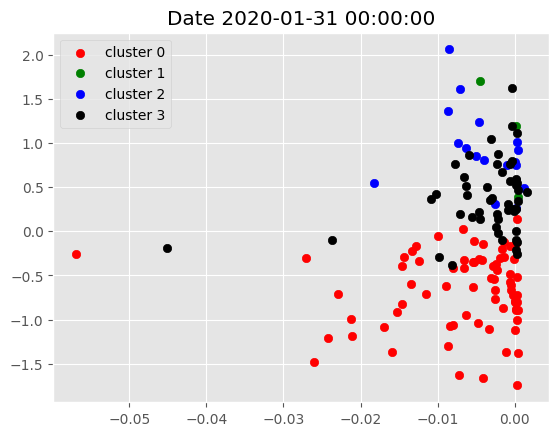

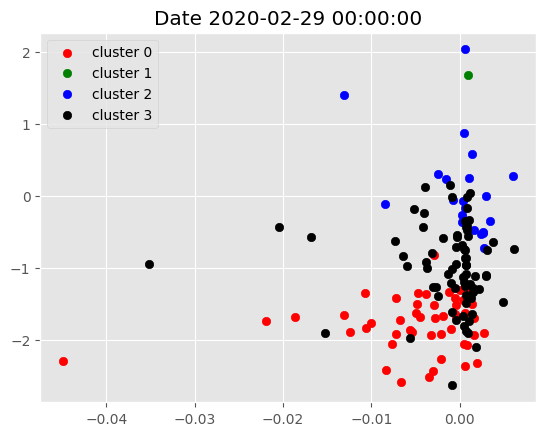

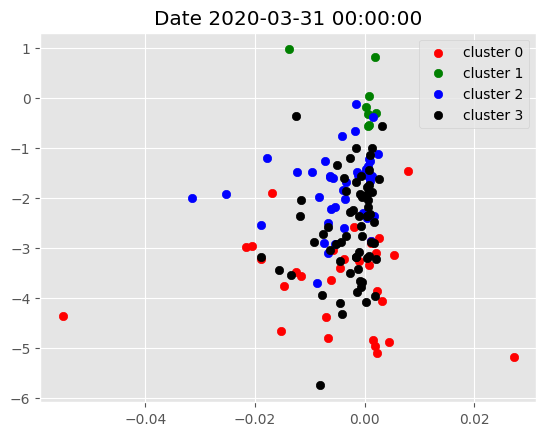

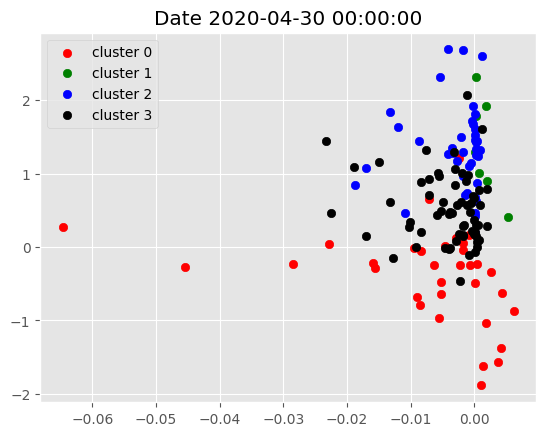

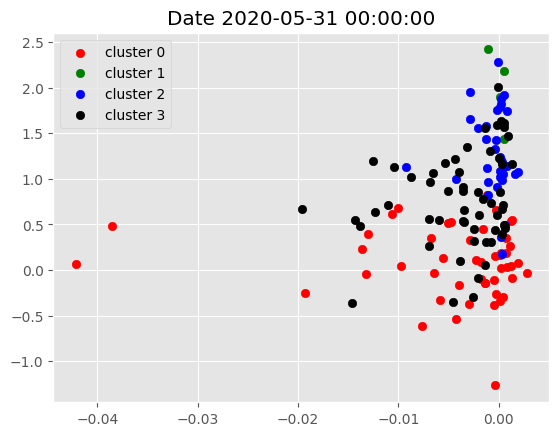

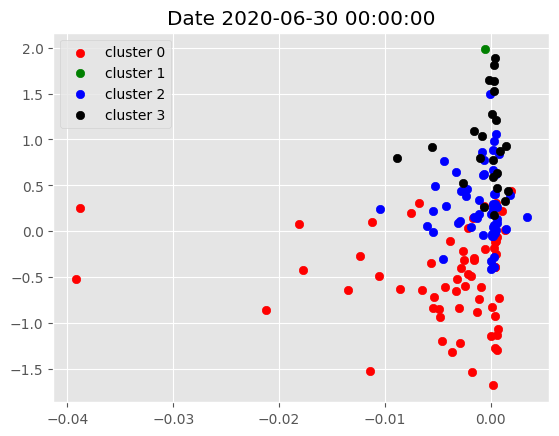

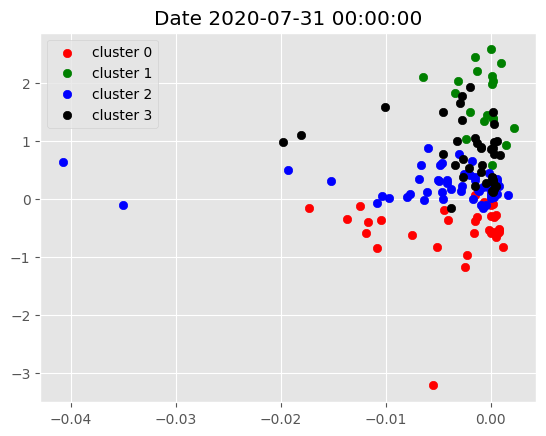

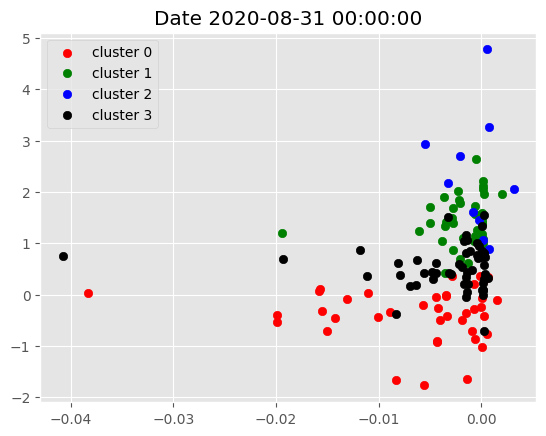

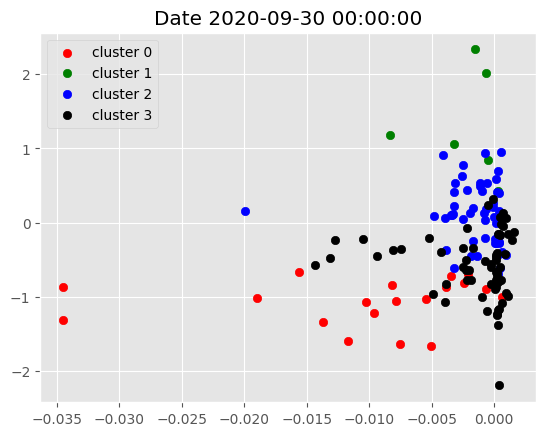

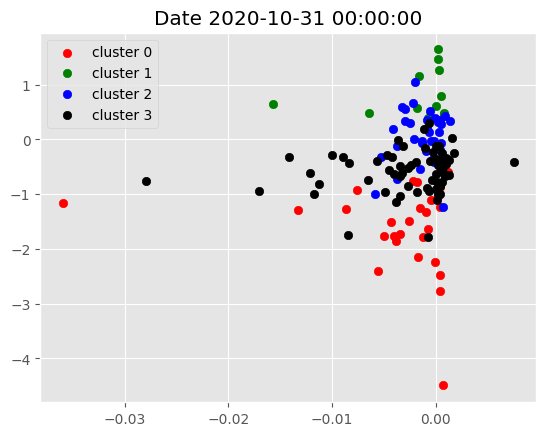

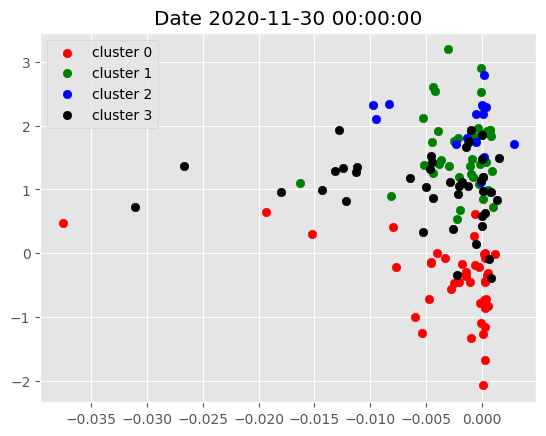

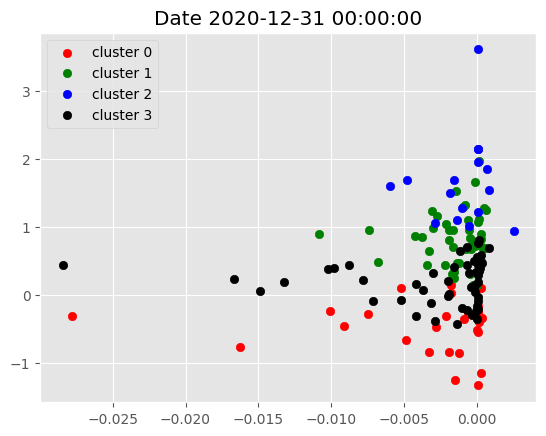

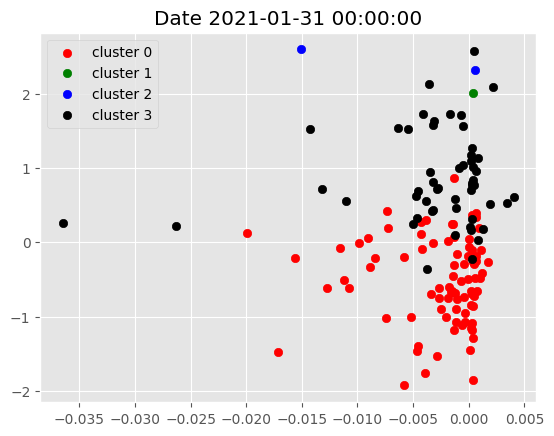

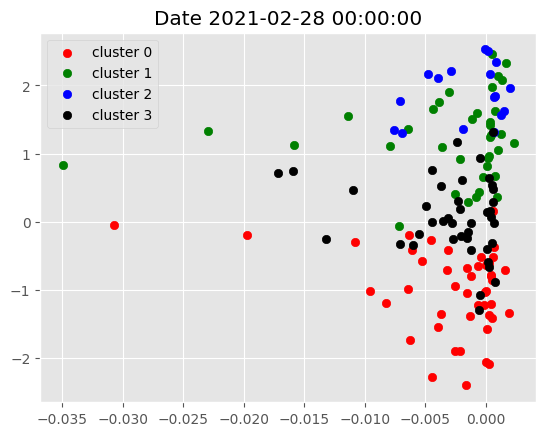

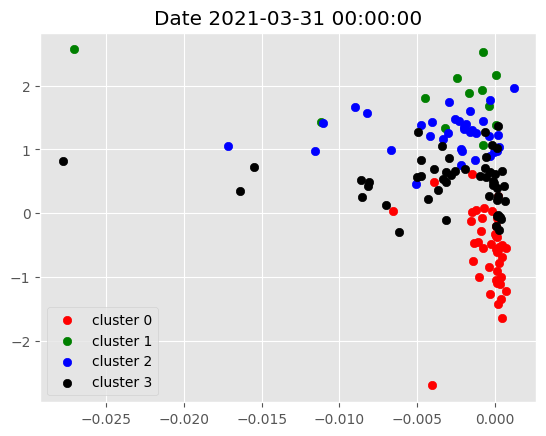

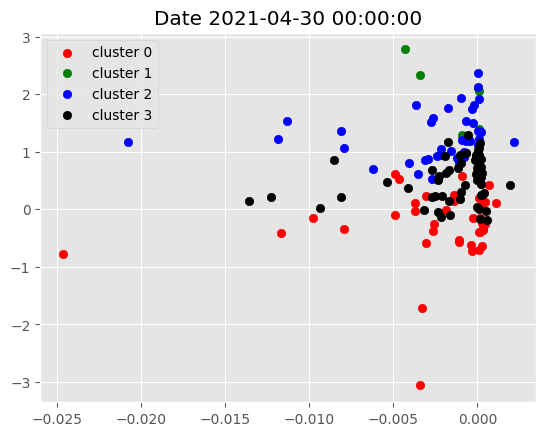

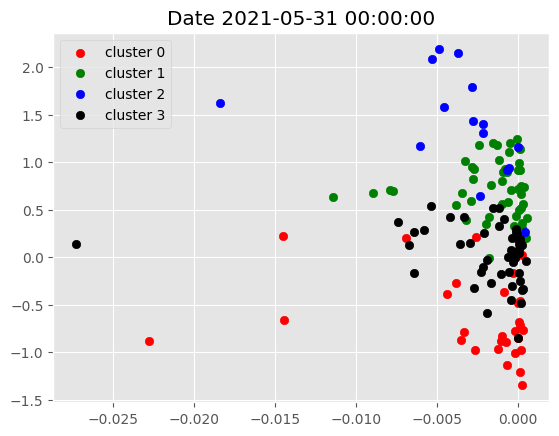

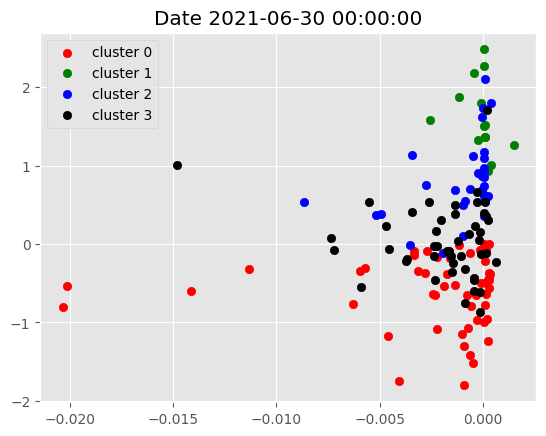

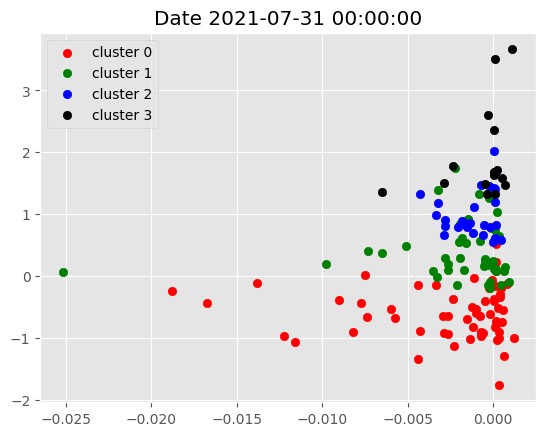

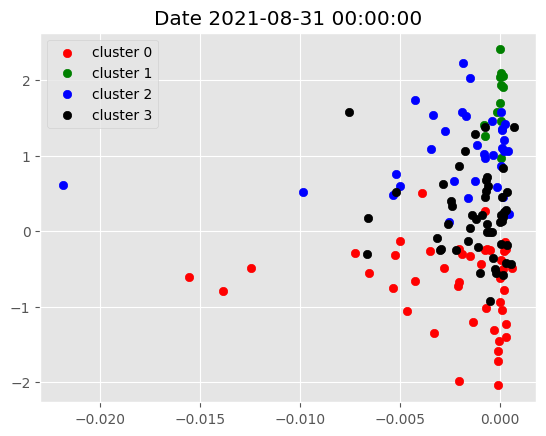

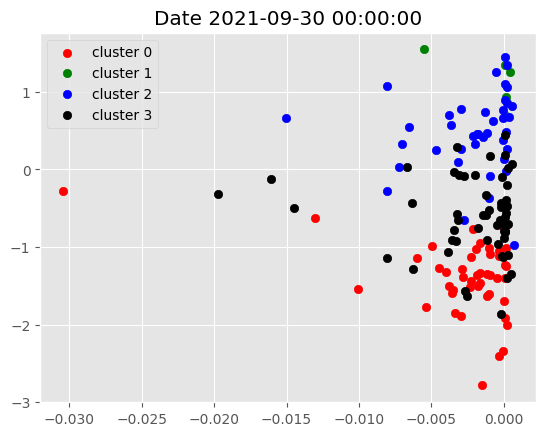

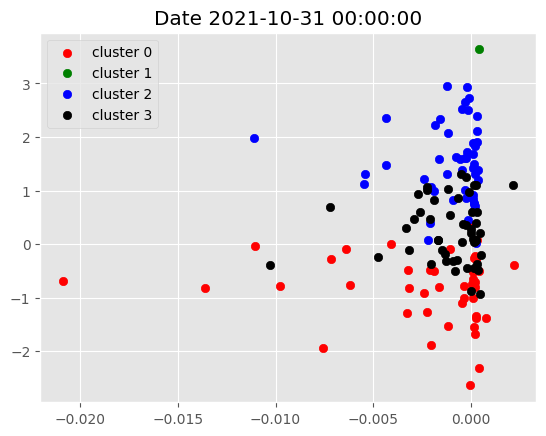

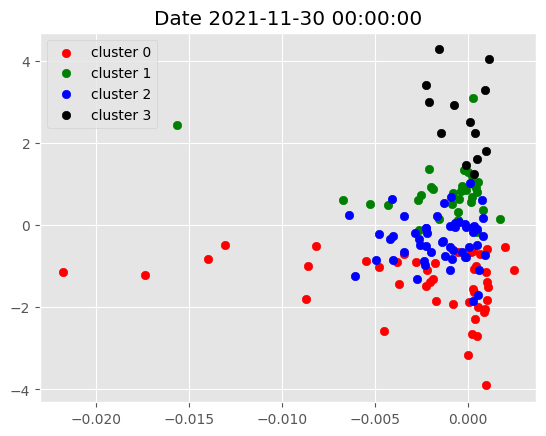

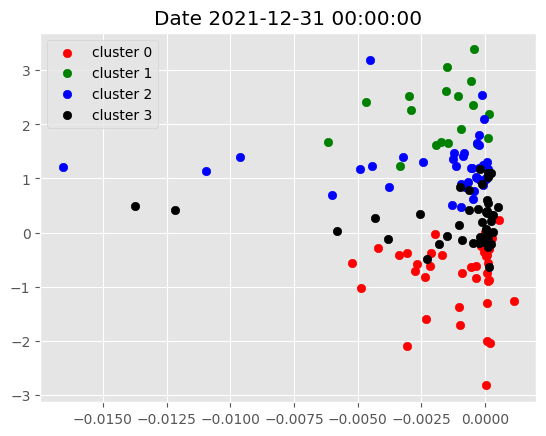

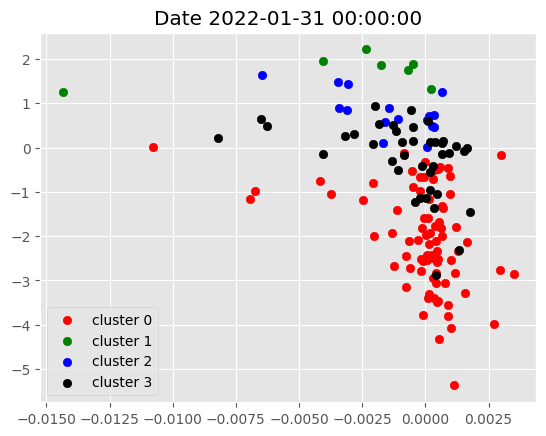

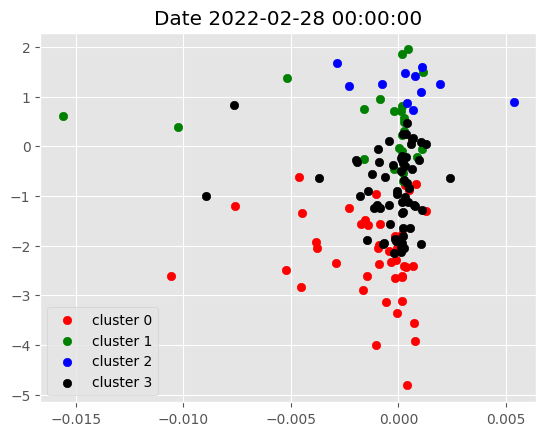

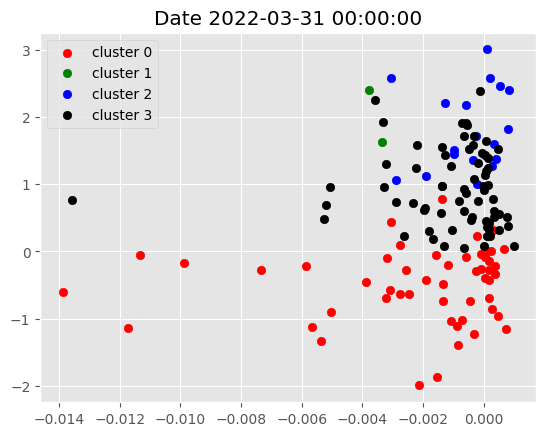

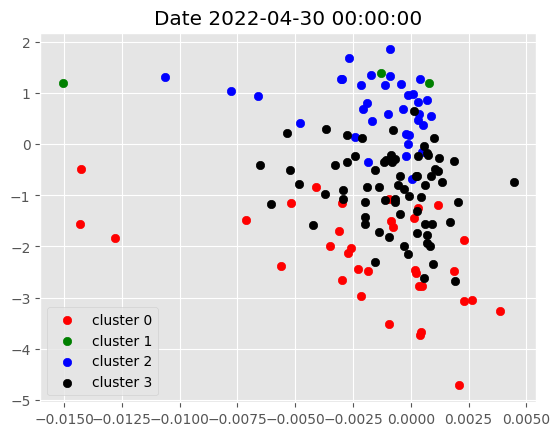

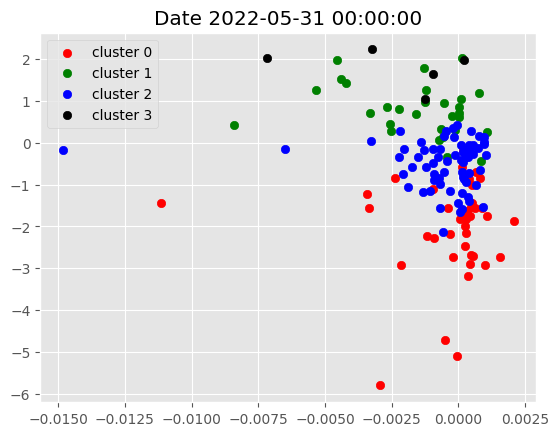

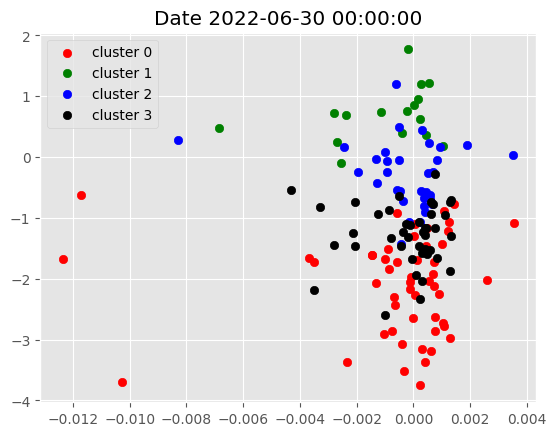

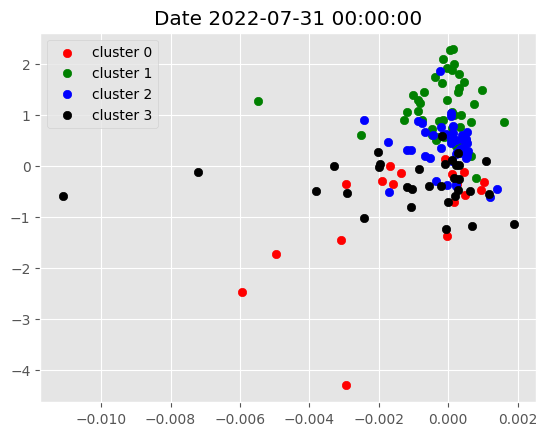

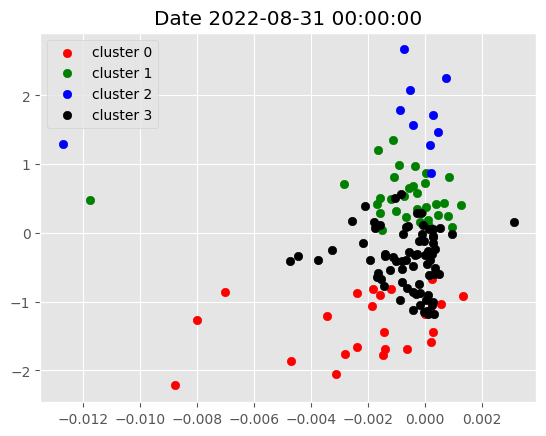

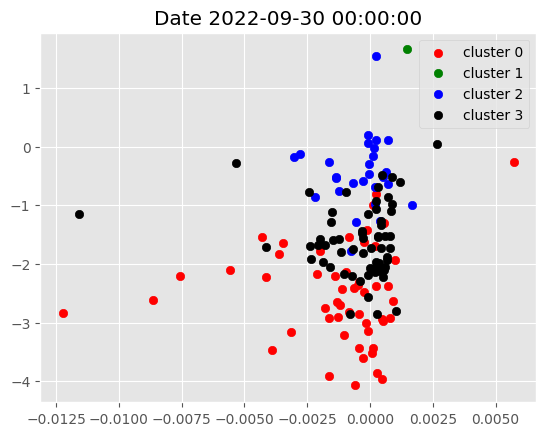

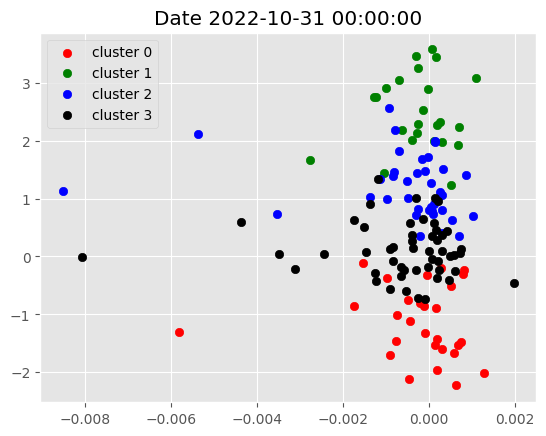

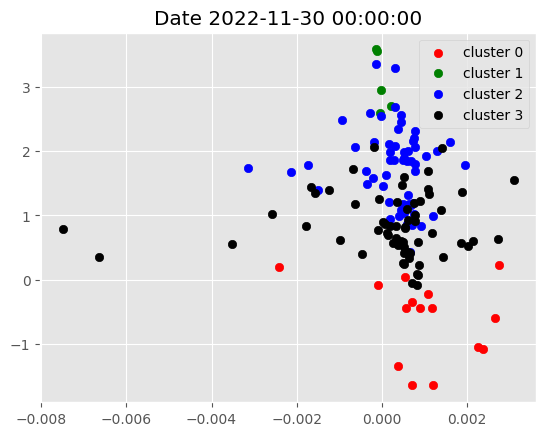

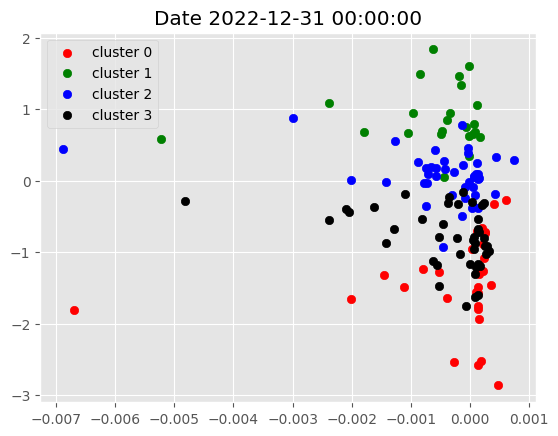

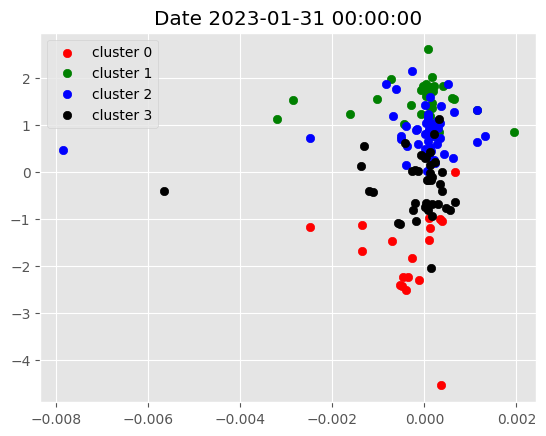

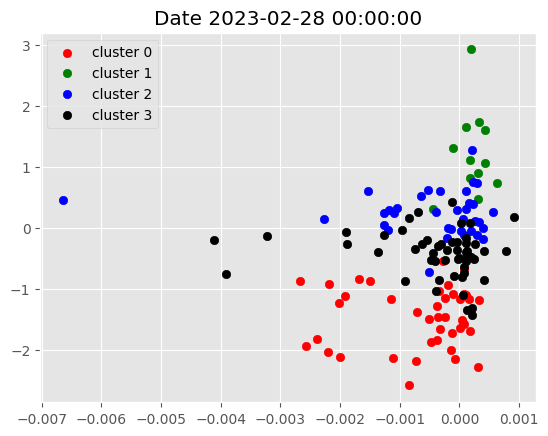

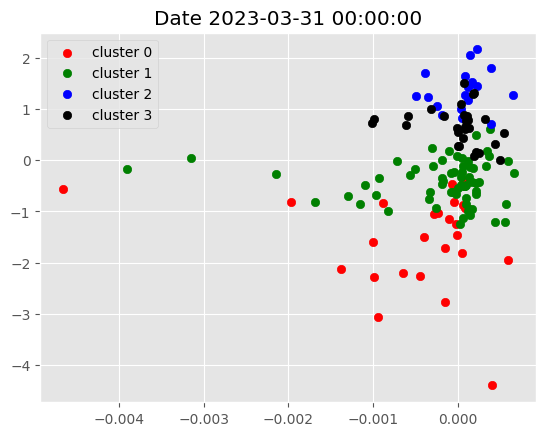

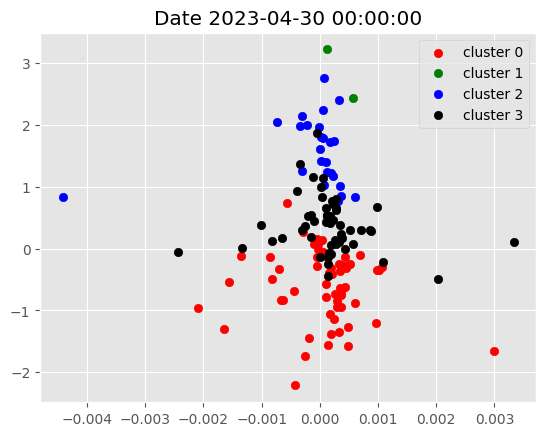

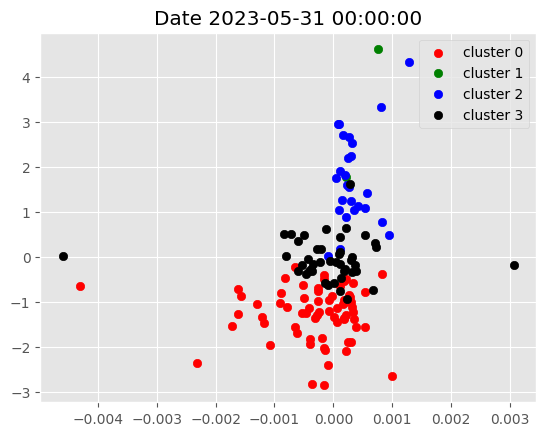

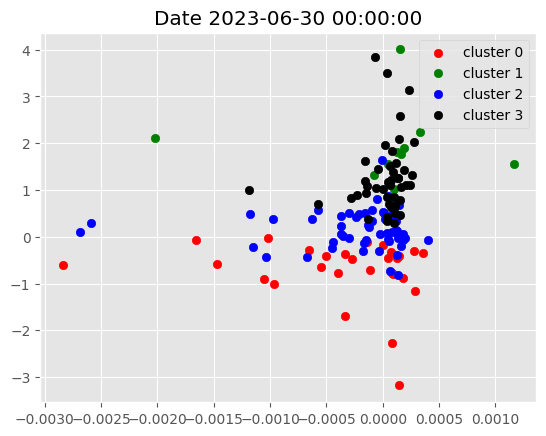

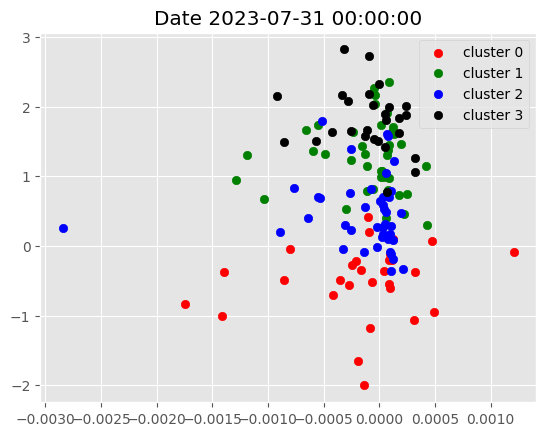

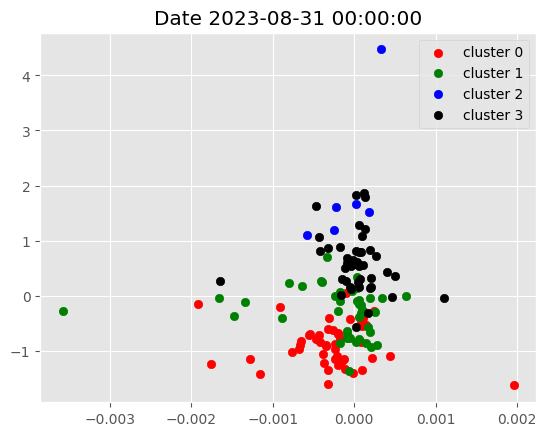

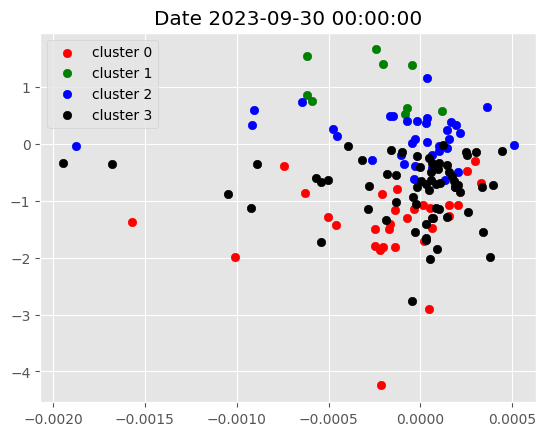

In [41]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [42]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'CCL',
  'COST',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'JNJ',
  'KO',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'ORLY',
  'OXY',
  'PANW',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CCL',
  'CL',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GD',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'C',
  'CCL',
  'CHTR',
  'CMCSA',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GD',
  'GOOG',
  'GOOGL',
  'GS',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
 

In [116]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    # Check if the covariance matrix is symmetric
    if not np.allclose(cov, cov.T):
        print("Covariance matrix is not symmetric, forcing symmetry.")
        cov = (cov + cov.T) / 2  # Force the covariance matrix to be symmetric

    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, .1), solver='SCS')

    weights = ef.max_sharpe()
    return ef.clean_weights()

In [117]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134323   26.182167   39.878788  34.112473  103.117386   
2016-11-01  38.363205   25.709440   40.357788  33.947300  103.028702   
2016-11-02  38.276459   25.732504   40.600864  33.643040  105.219833   
2016-11-03  38.054211   25.456682   39.957436  33.364857  103.747246   
2016-11-04  38.402081   25.227221   40.064667  33.982082  103.995651   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.183563  148.897141  95.484749  311.950897   
2023-09-26  12.700000  171.084549  148.184677  94.270004  305.672363   
2023-09-27  12.610000  169.562317  147.433685  93.584259  309.382385   
2023-09-28  12.920000  169.821014  146.586426  96.121513  295.988770   
2023-09-29  12.810000  170.338379  143.515091  94.877373  302.227966   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   73.831543   72.279999  50.462048   26.555433  ...   
2016-11-01  106.870003   73.712776   70.099998  49.627831   26.391054  ...   
2016-11-02  105.889999   76.307846   68.680000  49.521492   26.107979  ...   
2016-11-03  107.169998   75.756607   67.610001  47.558636   25.815750  ...   
2016-11-04  106.199997   75.544594   69.440002  46.928890   25.770094  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844101  205.669998  61.170822  135.559143  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.068085  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068111  134.040680  ...   
2023-09-28  504.670013  239.076828  207.889999  60.333942  137.176834  ...   
2023-09-29  509.899994  236.394348  206.910004  59.664440  137.405106  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 936 columns]

In [125]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
    
        cols = fixed_dates[start_date]
    
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime("%Y-%m-%d")
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(months=1)).strftime("%Y-%m-%d")

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, 
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True

        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T
            
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
           .merge(weights.stack().to_frame('weights').reset_index(level=0,drop=True),
                 left_index=True,
                 right_index=True)\
           .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weights']
    
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
        portfolio_df = pd.concat([portfolio_df,temp_df], axis=0)

    except Exception as e:
        
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.000023
2017-11-02,0.002007
2017-11-03,0.002924
2017-11-06,-0.000255
2017-11-07,-0.000971
...,...
2023-09-25,0.004799
2023-09-26,-0.015846
2023-09-27,0.006869


In [129]:
spy = yf.download(tickers='SPY',
                 start='2015-01-01',
                 end=dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.000023,0.001321
2017-11-02,0.002007,0.000388
2017-11-03,0.002924,0.003333
2017-11-06,-0.000255,0.001547
2017-11-07,-0.000971,-0.000696
...,...,...
2023-09-25,0.004799,0.004196
2023-09-26,-0.015846,-0.014800
2023-09-27,0.006869,0.000399
2023-09-28,0.009823,0.005781


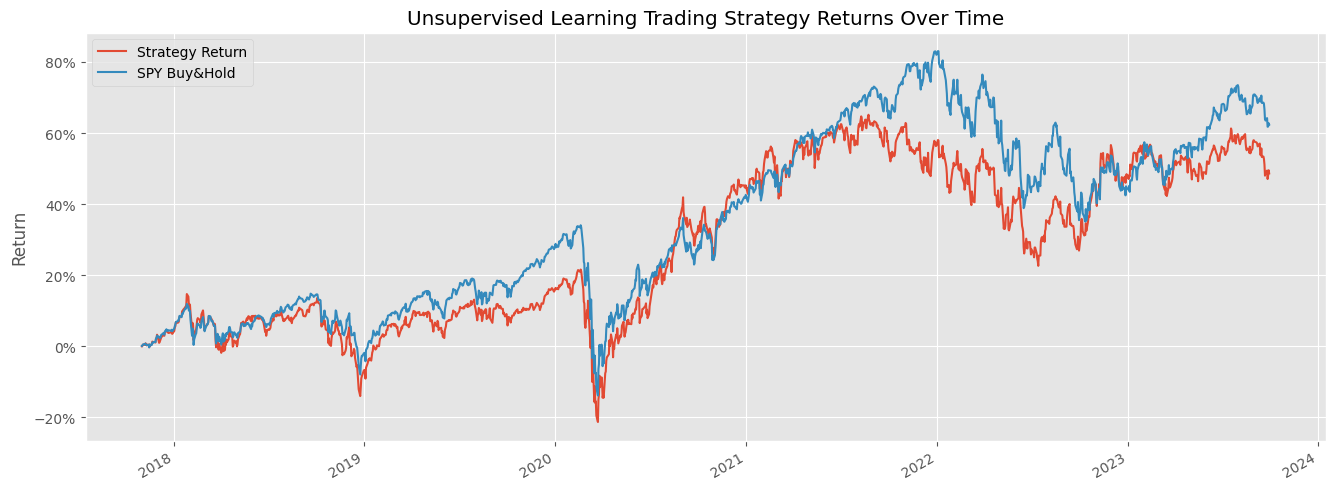

In [134]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-07-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()